## K-Means Clustering and PCA of Human Activity Recognition

학습 kernel : https://www.kaggle.com/ruslankl/k-means-clustering-pca
- 이 kernel을 보고 학습하였습니다.

학습 날짜 : 2019 - 06 - 15

### Intro

Clustering was always a subject I tried to avoid (for no reason). In this project I will finally use my knowledge of clustering and PCA algorithms to explore the Human Activity Recognition dataset. 

I would love to point on resourses I have learned from:

1. DataCamp Tutorial: [Python Machine Learning: Scikit-Learn Tutorial](https://www.datacamp.com/community/tutorials/machine-learning-python);

2. DataCamp course: [Unsupervised Learning in Python](https://www.datacamp.com/courses/unsupervised-learning-in-python/);

3. Cognitive Class course: [Machine Learning with Python](https://courses.cognitiveclass.ai/courses/course-v1:CognitiveClass+ML0101ENv3+2018/info);

4. And of course [Prof. Google](http://google.com)!

### Dataset info

Human Activity Recognition database built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors. The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (*WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING*) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. 

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
%matplotlib inline

np.random.seed(123)

In [6]:
data = pd.read_csv('./simplifiedhuarus/train.csv')

In [7]:
data.sample(5)

,rn,activity,tBodyAcc.mean.X,tBodyAcc.mean.Y,tBodyAcc.mean.Z,tBodyAcc.std.X,tBodyAcc.std.Y,tBodyAcc.std.Z,tBodyAcc.mad.X,tBodyAcc.mad.Y,...,fBodyBodyGyroJerkMag.meanFreq,fBodyBodyGyroJerkMag.skewness,fBodyBodyGyroJerkMag.kurtosis,angle.tBodyAccMean.gravity,angle.tBodyAccJerkMean.gravityMean,angle.tBodyGyroMean.gravityMean,angle.tBodyGyroJerkMean.gravityMean,angle.X.gravityMean,angle.Y.gravityMean,angle.Z.gravityMean
613,1739,WALKING_UPSTAIRS,0.241,-0.00873,-0.1060,-0.216,0.3220,-0.0801,-0.267,0.315,...,0.358,-0.726,-0.9410,0.86900,0.337,-0.916,0.7750,-0.686,0.314,0.034
2306,6598,WALKING_DOWNSTAIRS,0.238,-0.03990,-0.1580,0.284,0.2270,-0.1330,0.245,0.214,...,0.302,-0.190,-0.5850,0.09500,-0.684,0.937,-0.6360,-0.749,0.235,0.127
800,2291,LAYING,0.280,-0.02310,-0.0998,-0.978,-0.9650,-0.9690,-0.980,-0.964,...,0.494,-0.863,-0.9560,-0.12800,0.262,-0.098,0.0558,0.420,-0.278,-0.714
1621,4615,LAYING,0.320,0.03790,-0.1530,-0.642,-0.5340,-0.7920,-0.647,-0.615,...,0.309,-0.388,-0.7290,0.00812,-0.139,0.170,0.5200,0.685,-0.250,-0.760
1436,4111,WALKING,0.211,-0.04250,-0.0977,-0.324,-0.0342,-0.2350,-0.362,-0.031,...,0.241,0.320,0.0199,0.30500,-0.493,0.727,-0.4360,-0.572,0.344,0.182


In [9]:
print('Shape of the data set : ' + str(data.shape))

Shape of the data set : (3609, 563)


In [10]:
# save labels as string

Labels = data['activity']
data = data.drop(['rn', 'activity'], axis=1)
Labels_keys = Labels.unique().tolist()
Labels = np.array(Labels)

print('Activity labels : ' + str(Labels_keys))

Activity labels : ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']


In [11]:
# check for missing values

Temp = pd.DataFrame(data.isnull().sum())
Temp.columns = ['Sum']
print('Amount of rows with missing values: ' + str(len(Temp.index[Temp['Sum'] > 0])) )

Amount of rows with missing values: 0


In [12]:
# normalize the dataset

scaler = StandardScaler()
data = scaler.fit_transform(data)

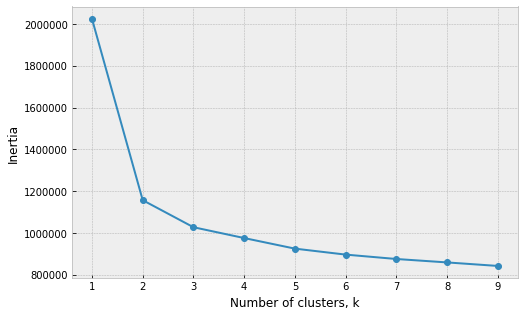

In [15]:
# check the optimal k value

ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(data)
    inertias.append(model.inertia_)
    
plt.figure(figsize=(8, 5))
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

**Looks like the best value ("elbow" of the line) for k is 2 (two clusters).**

In [19]:
def k_means(n_clust, data_frame, true_labels):
    """
    Function k_means applies k-means clustering alrorithm on dataset and prints the crosstab of cluster and actual labels 
    and clustering performance parameters.
    
    Input:
    n_clust - number of clusters (k value)
    data_frame - dataset we want to cluster
    true_labels - original labels
    
    Output:
    1 - crosstab of cluster and actual labels
    2 - performance table
    """
    
    k_means = KMeans(n_clusters=n_clust, random_state=123, n_init=30)
    k_means.fit(data_frame)
    c_labels=k_means.labels_
    
    df = pd.DataFrame(
        {'clust_label' : c_labels,
         'orig_label' : true_labels.tolist()
        }
    )
    
    ct = pd.crosstab(df['clust_label'], df['orig_label'])
    y_clust = k_means.predict(data_frame)
    display(ct)
    print('% 9s' % 'inertia  homo    compl   v-meas   ARI     AMI     silhouette')
    print('%i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
      %(k_means.inertia_,
      homogeneity_score(true_labels, y_clust),
      completeness_score(true_labels, y_clust),
      v_measure_score(true_labels, y_clust),
      adjusted_rand_score(true_labels, y_clust),
      adjusted_mutual_info_score(true_labels, y_clust),
      silhouette_score(data_frame, y_clust, metric='euclidean')))

In [20]:
k_means(n_clust=2, data_frame=data, true_labels=Labels)

orig_label,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
clust_label,,,,,,
0,680,622,668,0,0,6
1,1,1,0,603,493,535


inertia  homo    compl   v-meas   ARI     AMI     silhouette


/Users/wontaek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


1156484   0.378   0.981   0.546   0.329   0.378    0.390


**It looks like algorithm found patterns for Moving and Not-Moving activity with high level of accuracy.**

**Check how it will cluster by 6 clusters (original number of classes).**

In [22]:
k_means(n_clust=6, data_frame=data, true_labels=Labels)

orig_label,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
clust_label,,,,,,
0,554,21,0,0,0,0
1,0,0,0,248,311,97
2,1,0,0,329,107,438
3,20,445,479,0,0,0
4,0,0,0,26,75,4
5,106,157,189,0,0,2


inertia  homo    compl   v-meas   ARI     AMI     silhouette


/Users/wontaek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


895967   0.548   0.589   0.568   0.429   0.547    0.113


**Doesn't look like good connection between clusters and original labels so I will stick with 2 clusters.**

In [23]:
#change labels into binary: 0 - not moving, 1 - moving
Labels_binary = Labels.copy()
for i in range(len(Labels_binary)):
    if (Labels_binary[i] == 'STANDING' or Labels_binary[i] == 'SITTING' or Labels_binary[i] == 'LAYING'):
        Labels_binary[i] = 0
    else:
        Labels_binary[i] = 1
Labels_binary = np.array(Labels_binary.astype(int))

In [25]:
k_means(n_clust=2, data_frame=data, true_labels=Labels_binary)

orig_label,0,1
clust_label,,
0,1970,6
1,2,1631


inertia  homo    compl   v-meas   ARI     AMI     silhouette


/Users/wontaek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


1156484   0.977   0.978   0.978   0.991   0.977    0.390


### Principal component analysis (PCA)

> Principal Component Analysis is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set.

**2-cluster algorithm seems to fbe able to find patterns for moving/not-moving labels perfectly so far, but let's see if it can still be improved by dimension reduction. **

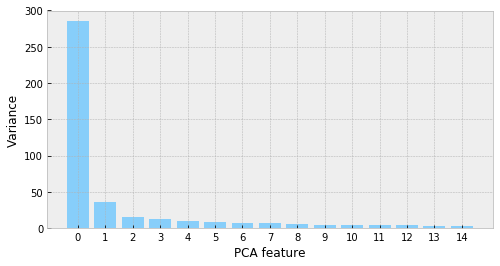

In [26]:
# check for optimal number of features

pca = PCA(random_state=123)
pca.fit(data)
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

In [28]:
pca.explained_variance_ratio_[0:15]

array([0.50817157, 0.06484235, 0.0276034 , 0.02367295, 0.0189342 ,
       0.01609669, 0.0136262 , 0.01194284, 0.00950276, 0.00921377,
       0.00882295, 0.00804799, 0.00777896, 0.00675024, 0.00651202])

**1 feature seems to be best fit for our algorithm.**

In [29]:
def pca_transform(n_comp):
    pca = PCA(n_components=n_comp, random_state=123)
    global Data_reduced
    
    Data_reduced = pca.fit_transform(data)
    print('Shape of the new Data df: ' + str(Data_reduced.shape))

In [30]:
pca_transform(n_comp=1)
k_means(n_clust=2, data_frame=Data_reduced, true_labels=Labels_binary)

Shape of the new Data df: (3609, 1)


orig_label,0,1
clust_label,,
0,1971,8
1,1,1629


inertia  homo    compl   v-meas   ARI     AMI     silhouette


/Users/wontaek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


168716   0.976   0.976   0.976   0.990   0.976    0.794


**Inertia and Silhouette seems to be much better now after reduction. **

**Just check clustering model for 2 components.**


In [31]:
pca_transform(n_comp=2)
k_means(n_clust=2, data_frame=Data_reduced, true_labels=Labels_binary)

Shape of the new Data df: (3609, 2)


orig_label,0,1
clust_label,,
0,1969,6
1,3,1631


inertia  homo    compl   v-meas   ARI     AMI     silhouette
295753   0.975   0.975   0.975   0.990   0.975    0.694


/Users/wontaek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


**No improvements here.**

**So far it seems like this was best I could do. Still learning clustering algorithms and I might come back to this project later.**

**If you know any interesting dataset to practice clustering on (not Iris dataset, haha), please suggest!**